# Lab 2 Quantization

Originally developed by instructor Sophia (Yakun) Shao and TAs Alon Amid & Hasan Genc from UC Berkeley, 2020 Spring, "Hardware for Machine Learning". Adpated by 2024 Fall "AI Computing Systems" teaching team.

You are required to fill in the blanks with your code **independently** to complete the quantization process (weights, activations and biases quantization), so we can simulate and verify the quantized NN model on floating-point hardware (CPUs or GPGPUs). It provides us the confidence that the model can be run on a customized 8-bit hardware with limited loss of accuracy. 

**Throughout this experiment, we use symmetric quantization, which means the "zero point" should be 0. Please make sure your results are reproducible and do not change the structure of the CNN (1 point)**.


## Initial Setup

Before beginning the assignment, we import the CIFAR dataset, and train the simple convolutional neural network (CNN) built in Lab1 to classify it.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

**Reminder:** set the runtime type to "GPU" if it is available. 

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
torch.manual_seed(2024219)

Load training and test data from the CIFAR10 dataset.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/home/ubuntu/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=False, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='/home/ubuntu/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


The simple CNN that classifies CIFAR images is built in Lab 1 and has the has the following architecture:

**Layer** | **Type** | **Input Shape** | **Output Shape** | **Activation**
--- | --- | --- | --- | ---
conv1 | Convolutional | 3x32x32 | 12x28x28 | ReLU 
pool1 | Max pool | 12x28x28 | 12x14x14 | None                
conv2 | Convolutional | 12x14x14 | 32x12x12 | ReLU                
pool2 | Max pool | 32x12x12 | 32x6x6 | None                
fc1 | Fully-connected | 1152 | 256 | ReLU                
fc2 | Fully-connected | 256 | 64 | ReLU                
fc3 | Fully-connected | 64 | 10 | None                

None of the layers in the network have a bias associated with them.
This makes them easier to quantize.
Towards the end of this assignment, we will add biases to the final layer and quantize it as well.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2) # run after each conv (hence the 5x5 FC layer)
        self.conv2 = nn.Conv2d(12, 32, 3, bias=False)
        self.fc1 = nn.Linear(32 * 6 * 6, 256, bias=False)
        self.fc2 = nn.Linear(256, 64, bias=False)
        self.fc3 = nn.Linear(64, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

Define the training and testing process.

In [5]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)

    for epoch in range(10):  # loop over the dataset multiple (2) times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[Epoch: %d, Iteration: %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # get 1 batch worth of image predictions (i.e. 4 predictions of 10 each)
            other, predicted = torch.max(outputs.data, 1) # other == values, predicted == indicies
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break
    
    return 100 * correct / total

Train this CNN on the training dataset (this may take 20 seconds).

In [6]:
train(net, trainloader)

[Epoch: 1, Iteration:   100] loss: 2.278
[Epoch: 1, Iteration:   200] loss: 1.994
[Epoch: 1, Iteration:   300] loss: 1.715
[Epoch: 1, Iteration:   400] loss: 1.616
[Epoch: 1, Iteration:   500] loss: 1.524
[Epoch: 2, Iteration:   100] loss: 1.432
[Epoch: 2, Iteration:   200] loss: 1.391
[Epoch: 2, Iteration:   300] loss: 1.303
[Epoch: 2, Iteration:   400] loss: 1.265
[Epoch: 2, Iteration:   500] loss: 1.228
[Epoch: 3, Iteration:   100] loss: 1.161
[Epoch: 3, Iteration:   200] loss: 1.154
[Epoch: 3, Iteration:   300] loss: 1.084
[Epoch: 3, Iteration:   400] loss: 1.067
[Epoch: 3, Iteration:   500] loss: 1.030
[Epoch: 4, Iteration:   100] loss: 0.988
[Epoch: 4, Iteration:   200] loss: 0.989
[Epoch: 4, Iteration:   300] loss: 0.937
[Epoch: 4, Iteration:   400] loss: 0.929
[Epoch: 4, Iteration:   500] loss: 0.889
[Epoch: 5, Iteration:   100] loss: 0.885
[Epoch: 5, Iteration:   200] loss: 0.867
[Epoch: 5, Iteration:   300] loss: 0.804
[Epoch: 5, Iteration:   400] loss: 0.809
[Epoch: 5, Itera

Now that the CNN has been trained, let's test it on our test dataset. The test accuracy should be above 60% after 10 epochs of training.  **Report this accuracy (1 point).**

In [7]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 63.77%


Define a convenience function which we use to copy CNN's for version control.

In [8]:
from copy import deepcopy

def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

## Question 1: Visualize Weights
### Question 1.1:

Plot histograms of the weights of every convolutional and fully-connected layer. Record any observations you make about the distribution of the values and report.

In [9]:
# Possible required lib
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor

**ADD YOUR CODE HERE to plot distributions of weights of the original NN model. Add them to the report (0.5 point)**

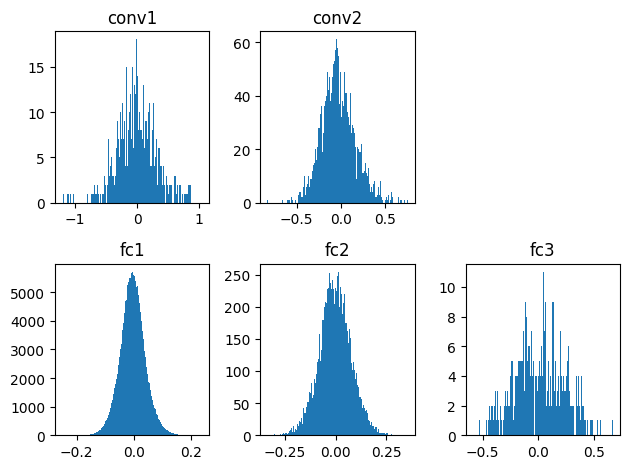

In [10]:
# ADD YOUR CODE HERE

# You can get a flattened vector of the weights of fc1 like this:
# Try plotting a histogram of fc1_weights (and the weights of all the other layers as well)
conv1_weights = net.conv1.weight.data.cpu().view(-1)
conv2_weights = net.conv2.weight.data.cpu().view(-1)
fc1_weights = net.fc1.weight.data.cpu().view(-1)
fc2_weights = net.fc2.weight.data.cpu().view(-1)
fc3_weights = net.fc3.weight.data.cpu().view(-1)
fig, axs = plt.subplots(2, 3)

axs[0, 0].hist(conv1_weights, bins=256)
axs[0, 0].set_title("conv1")

axs[0, 1].hist(conv2_weights, bins=256)
axs[0, 1].set_title("conv2")

axs[0, 2].axis('off')

axs[1, 0].hist(fc1_weights, bins=256)
axs[1, 0].set_title("fc1")

axs[1, 1].hist(fc2_weights, bins=256)
axs[1, 1].set_title("fc2")

axs[1, 2].hist(fc3_weights, bins=256)
axs[1, 2].set_title("fc3")

plt.tight_layout()
plt.show()
# You can use "hist" from the matplotlib.pyplot package.

### Question 1.2:

Record the range of the weights, as well as their 3-sigma range (the difference between $\mu + 3\sigma$ and $\mu - 3\sigma$).
For which layers is the 3-sigma range larger or smaller than the actual range?

**ADD YOUR CODE HERE to record the 3-sigma and actual range of the weights in each layer. Report the results (0.5 point)**

In [11]:
# Useful functions: torch.min/max/mean/std
weights = [conv1_weights, conv2_weights, fc1_weights, fc2_weights, fc3_weights]
names = ["conv1", "conv2", "fc1", "fc2", "fc3"]
def mean_and_var(x: Tensor, n:int):
    mean = torch.mean(x)
    variance = torch.var(x)
    if (torch.max(x) > mean + n * variance or torch.min(x) < mean - n * variance):
        return False
    else:
        return True
for w, n in zip(weights, names):
    if (mean_and_var(w, 3)):
        print(f"weights {n} is in 3-sigma")
    else:
        print(f"weights {n} is out of 3-sigma")



weights conv1 is out of 3-sigma
weights conv2 is out of 3-sigma
weights fc1 is out of 3-sigma
weights fc2 is out of 3-sigma
weights fc3 is out of 3-sigma


## Question 2: Quantize Weights

Any convolution or fully-connected layer pass, without a bias, can be described by the equation:

$$W*In = Out$$

where $W$ is the weight tensor, $In$ in the input tensor, and $Out$ is the output tensor.

For this question, your task is to find a *scaling factor*, called $s_W$ for each convolutional and fully connected layer,
which would fit inside an 8-bit signed integer.
This equation can now be described as the following:

<!-- $$/*In = Out/s_W$$ -->
$$\frac{W}{s_W}*In = \frac{Out}{s_W}$$

You might wonder: "Isn't it a problem that the output of the layer has now changed? Wouldn't quantizing the weights change the output of the neural net?"

The answer, of course, is: "Yes".
However, what we care about is not the *absolute* values output by the CNN, but the relative difference between the probabilities it assigns to different classes for its predictions.
Quantizing the weights only scales this relative difference up or down, but it does not affect which class the network assigns the most probability to.
Therefore, it does not affect the final predictions that the neural net makes.

Copy the original model into a new model.

In [12]:
net_q2 = copy_model(net)

### Question 2.1:

**Fill in the `quantized_weights` function.**
The template code we provide will then call this function on the weights of every layer in the CNN that we just trained at 32-bit floating point precision, to lower them into 8-bit signed integer (2'complement, -128~127) precision.

In [13]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the maxmimum absolute value of total range, 3-sigma range, 
    or other ranges for symmetric quantization when deciding just what factors to 
    scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    ''' 
    ADD YOUR CODE HERE to compute 'result' and change 'scale'. 
    We consider only symmetric quantization, which means zeros point is exactly 0.
    After that, return the 'scale' together with the quantized number, 'result', in [-128,127].
    '''
    max_value = weights.__abs__().max().item()
    scale = 128 / (max_value)
    result = (weights * scale).round()
    return torch.clamp(result, min=-128, max=127), scale

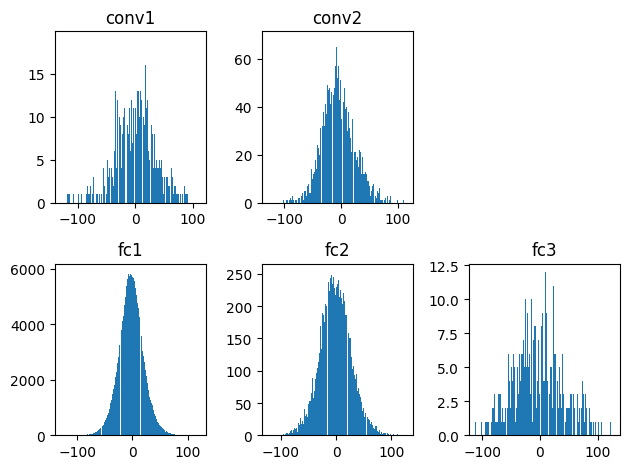

In [14]:
def quantize_layer_weights(model: nn.Module):
    # Quantize the weights layer by layer and record the scale factors and quantized weights
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            # Quantize the weights using the function you just developed
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale
            
            # Check if the weights are quantized properly, your code should be okay if no exception is raised.
            # Otherwise, please check your code.
            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))


quantize_layer_weights(net_q2)

conv1_weights = net_q2.conv1.weight.data.cpu().view(-1)
conv2_weights = net_q2.conv2.weight.data.cpu().view(-1)
fc1_weights = net_q2.fc1.weight.data.cpu().view(-1)
fc2_weights = net_q2.fc2.weight.data.cpu().view(-1)
fc3_weights = net_q2.fc3.weight.data.cpu().view(-1)
fig, axs = plt.subplots(2, 3)

axs[0, 0].hist(conv1_weights, bins=256)
axs[0, 0].set_title("conv1")

axs[0, 1].hist(conv2_weights, bins=256)
axs[0, 1].set_title("conv2")

axs[0, 2].axis('off')

axs[1, 0].hist(fc1_weights, bins=256)
axs[1, 0].set_title("fc1")

axs[1, 1].hist(fc2_weights, bins=256)
axs[1, 1].set_title("fc2")

axs[1, 2].hist(fc3_weights, bins=256)
axs[1, 2].set_title("fc3")

plt.tight_layout()
plt.show()

### Question 2.2:

**Record the accuracy change of the network after quantizing its weights and report. (1 point)**

In [15]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 63.85%


## Question 3: Visualize Activations

Now that we have quantized the weights of the CNN, we must also quantize the activations (inputs and outputs to layers) traveling through it.
But before doing so, let's analyze what values the activations take when travelling through the network.

We provide convenience code which will record the values of every pixel of the outputs and inputs travelling through the neural network.
(This is the initial CNN, where not even the weights had yet been quantized).
We then profile these values when running on a subset of the training set (calibration data).

In [16]:
def register_activation_profiling_hooks(model: Net):
    # initialize the activations with empty ndarray
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)
    # function register_forward_hook is used to obtain the activations, which would otherwise be abandoned as
    # intermediate variables. For more details, please refer to 
    # https://pytorch.org/docs/stable/notes/modules.html#module-initialization
    # Module Hooks

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


Use the unquantized model to profile input and output activations on a subset of the training dataset.

In [17]:
net_q3 = copy_model(net)
# activate the hook record activations
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=1000)
net_q3.profile_activations = False

In [18]:
# Fetch the activations
input_activations = net_q3.input_activations
conv1_output_activations = net_q3.conv1.activations
conv2_output_activations = net_q3.conv2.activations
fc1_output_activations = net_q3.fc1.activations
fc2_output_activations = net_q3.fc2.activations
fc3_output_activations = net_q3.fc3.activations

### Question 3.1:

**Plot histograms of the input images and the outputs of every convolutional and fully-connected layer. 
Record any observations you make about the distribution of the values. (0.5 point)** Remember that you are plotting the activations *after* activation functions like ReLU have been applied, which means that you should not be worried if you find that your plots are asymmetric.

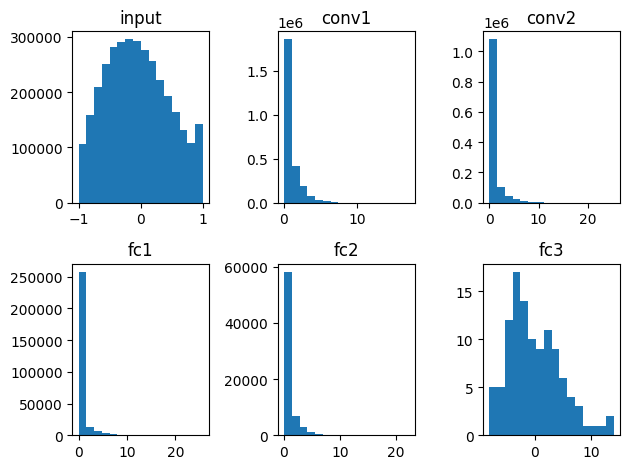

In [19]:
# ADD YOUR CODE HERE to plot distributions of activations
# Plot histograms of the following variables:
#   input_activations
#   conv1_output_activations
#   conv2_output_activations
#   fc1_output_activations
#   fc2_output_activations
#   fc3_output_activation
fig, axs = plt.subplots(2, 3)

bins = 16

axs[0, 0].hist(input_activations, bins=bins)
axs[0, 0].set_title("input")

axs[0, 1].hist(conv1_output_activations, bins=bins)
axs[0, 1].set_title("conv1")

axs[0, 2].hist(conv2_output_activations, bins=bins)
axs[0, 2].set_title("conv2")

axs[1, 0].hist(fc1_output_activations, bins=bins)
axs[1, 0].set_title("fc1")

axs[1, 1].hist(fc2_output_activations, bins=bins)
axs[1, 1].set_title("fc2")

axs[1, 2].hist(fc3_output_activations, bins=bins)
axs[1, 2].set_title("fc3")

plt.tight_layout()
plt.show()
# You can use "hist" from the matplotlib.pyplot package.

### Question 3.2:

Additionally, **report the range of the values, as well as their 3-sigma range (the difference between $\mu + 3\sigma$ and $\mu - 3\sigma$) (0.5 point)**.
For which layers is the 3-sigma range larger or smaller than the actual range?

In [20]:
# ADD YOUR CODE HERE to record the range and 3-sigma range of the activations
weights = [
    input_activations,
    conv1_output_activations, 
    conv2_output_activations, 
    fc1_output_activations, 
    fc2_output_activations, 
    fc3_output_activations
]

names = ["input", "conv1", "conv2", "fc1", "fc2", "fc3"]

for w, n in zip(weights, names):
    if (mean_and_var(Tensor(w), 3)):
        print(f"weights {n} is in 3-sigma")
    else:
        print(f"weights {n} is out of 3-sigma")


weights input is out of 3-sigma
weights conv1 is out of 3-sigma
weights conv2 is out of 3-sigma
weights fc1 is out of 3-sigma
weights fc2 is out of 3-sigma
weights fc3 is in 3-sigma


## Question 4: Quantize Activations

Now it is time to quantize the activations (inputs and outputs to layers) traveling through the CNN.
Our equation now becomes:

$$\frac{W}{s_W}*\frac{In}{s_{In}}*\frac{1}{s_{Out} }= \frac{Out}{s_Ws_{In}s_{Out}}$$

where $s_{In}$ is the scaling factor which was applied to the input to the layer, and $s_{Out}$ is the scaling factor which we decide to apply to the output of the layer.
$s_{Out}$ must be chosen such that the expected values of the elements of $Out$ can be scaled down to fit within 8 bits.

### Question 4.1:

Before performing any quantization at all, we could describe the output of the `conv1` layer as:

$$W_{conv1} * In = Out_{conv1}$$

Suppose that we quantized the input matrix, $In$, scaling it by $s_{In}$.
Suppose that we also scaled the weight matrix, $W_{conv1}$, by $s_{W_{conv1}}$, and the output matrix, $Out_{conv1}$, by $s_{Out_{conv1}}$.

**In the lab report answer the following sub-questions for 4.1 (1 point).**:

**(a)** Write an equation describing the output of the `conv1` layer with these new scaling parameters.

**(b)** Write an equation describing the output of the `conv2` layer in terms of $In$, $W_{conv1}$, $W_{conv2}$, $Out_{conv1}$, $Out_{conv2}$, $s_{In}$, $s_{W_{conv1}}$, $s_{W_{conv2}}$, $s_{Out_{conv1}}$, and $s_{Out_{conv2}}$.
You can pretend that the pooling layers do not exist.

### Question 4.2:

**Complete the `quantize_initial_input` and `quantize_activations` functions which calculate the scaling factors for the initial image which is input to the CNN, and the outputs of each layer, respectively.** Again you can use 3-sigma range or min-max range.

### Question 4.3:

**Complete the `forward` function for the `NetQuantized` class.
You will have to add code here to scale the outputs of each layer, and then to clamp the outputs of each layer to integers between -128 and 127 afterwards.**

**Be careful with the data type (ndarray/tensor/scalar/tuple/float) specified and required by each function.**

In [21]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()
        
        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))
        
        self.scaleList:list[tuple[str, float]] = [
            ("input", self.input_scale),
            ("conv1", self.conv1.output_scale),
            ("conv2", self.conv2.output_scale),
            ("fc1", self.fc1.output_scale),
            ("fc2", self.fc2.output_scale),
            ("fc3", self.fc3.output_scale),
        ]

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.
        Remember to use symmetric scaling (zero-point = 0)
        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''
        max_value = pixels.__abs__().max()
        result:float = 128 / max_value

        return result

    @staticmethod
    def quantize_activations(activations: np.ndarray, s_w: float, s_initial_input: float, ss: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.
        Remember to use symmetric scaling (zero-point = 0)
        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        s_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        s_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ss ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''
        result:float
        max_value = activations.__abs__().max()
        divident: float = s_initial_input * s_w
        for (weight_scale, output_scale) in ss:
            divident *= weight_scale * output_scale
    
        result = (128 / max_value) / divident
        
        return result



    def forward(self, x: torch.Tensor) -> torch.Tensor:
        def quantize(x: torch.Tensor, index: int):
            scale = self.scaleList[index][1]
            y = x * scale
            y = torch.round(y)
            return torch.clamp(y, min=-128, max=127)

        x = quantize(x, 0)

        x = self.conv1(x)
        x = quantize(x, 1)
        x = self.pool(F.relu(x))

        x = self.conv2(x)
        x = quantize(x, 2)
        x = self.pool(F.relu(x))

        x = x.view(-1, 32 * 6 * 6)

        x = self.fc1(x)
        x = quantize(x, 3)
        x = F.relu(x)

        x = self.fc2(x)
        x = quantize(x, 4)
        x = F.relu(x)

        x = self.fc3(x)
        x = quantize(x, 5)

        return x

In [22]:
# Merge the information from net_q2 and net_q3 together
net_init = copy_model(net_q2)  
net_init.input_activations = deepcopy(net_q3.input_activations) 
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

### Question 4.4:

Finally, record the accuracy of your network after both weights and activations have been quantized.
If you've done everything right, you should still find little accuracy change. **Report the accuracy. (1 point)**

In [23]:
score = test(net_quantized, testloader)    
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Accuracy of the network after quantizing both weights and activations: 63.45%


## Question 5: Quantize Biases
Let us now update our CNN to include a bias in its final layer, *fc3*.
We have already included code to create and train a new CNN called `net_with_bias`.

Consider how a bias affects the equation for an unquantized layer:

$$W * In + \beta = Out$$

where $\beta$ is the bias.

### Question 5.1:

Suppose that we again quantized a biased layer with the same scaling factors we used in previous questions: $s_W$, $s_{In}$, and $s_{Out}$.
What would we scale $\beta$ by in this case?
**Write an equation in your lab report to describe the output of the quantized layer with a bias (1 point).**

Create a new network with a bias on *fc3*.

In [24]:
class NetWithBias(nn.Module):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.conv1 = nn.Conv2d(3, 12, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 3, bias=False)
        self.fc1 = nn.Linear(32 * 6 * 6, 256, bias=False)
        self.fc2 = nn.Linear(256, 64, bias=False)
        self.fc3 = nn.Linear(64, 10, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_bias = NetWithBias().to(device)

Train and score the network.

In [25]:
train(net_with_bias, trainloader)

[Epoch: 1, Iteration:   100] loss: 2.254
[Epoch: 1, Iteration:   200] loss: 1.929
[Epoch: 1, Iteration:   300] loss: 1.677
[Epoch: 1, Iteration:   400] loss: 1.592
[Epoch: 1, Iteration:   500] loss: 1.514
[Epoch: 2, Iteration:   100] loss: 1.429
[Epoch: 2, Iteration:   200] loss: 1.377
[Epoch: 2, Iteration:   300] loss: 1.284
[Epoch: 2, Iteration:   400] loss: 1.284
[Epoch: 2, Iteration:   500] loss: 1.219
[Epoch: 3, Iteration:   100] loss: 1.168
[Epoch: 3, Iteration:   200] loss: 1.159
[Epoch: 3, Iteration:   300] loss: 1.094
[Epoch: 3, Iteration:   400] loss: 1.089
[Epoch: 3, Iteration:   500] loss: 1.043
[Epoch: 4, Iteration:   100] loss: 0.991
[Epoch: 4, Iteration:   200] loss: 0.996
[Epoch: 4, Iteration:   300] loss: 0.946
[Epoch: 4, Iteration:   400] loss: 0.942
[Epoch: 4, Iteration:   500] loss: 0.904
[Epoch: 5, Iteration:   100] loss: 0.862
[Epoch: 5, Iteration:   200] loss: 0.871
[Epoch: 5, Iteration:   300] loss: 0.827
[Epoch: 5, Iteration:   400] loss: 0.834
[Epoch: 5, Itera

In [26]:
score = test(net_with_bias, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))

Accuracy of the network (with a bias) on the test images: 62.63%


Test the network with quantized weights but unquantized bias and **report the accuracy (1 point)**.

In [27]:
register_activation_profiling_hooks(net_with_bias)
test(net_with_bias, trainloader, max_samples=400)
net_with_bias.profile_activations = False

In [28]:
net_with_bias_with_quantized_weights = copy_model(net_with_bias)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 60.38%


### Question 5.2:

Fill in the `quantized_bias` function in the `NetQuantizedWithBias` class.
This function is meant to quantize the bias on the final layer of the CNN. You are suggested to use the method covered in the lecture.
Keep in mind that biases are typically quantized to 32-bits, so your bias values do not all have to be between -128 and 127 (though 32-bits is a bit conservative).

In [29]:
# slightly clearer bias bounds (32b signed integer)
MIN_32B_SINT = -(2**31)
MAX_32B_SINT = (2**31) - 1

In [30]:
class NetQuantizedWithBias(NetQuantized): # get quantized weights & activations
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized)
        
        preceding_scales = [(layer.weight.scale, layer.output_scale) for layer in self.children() if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)][:-1]

        print(self.fc3.bias.data)
        self.fc3.bias.data = NetQuantizedWithBias.quantized_bias(
            self.fc3.bias.data,
            self.fc3.weight.scale,
            self.input_scale,
            preceding_scales
        )
        print(self.fc3.bias.data)

        if (self.fc3.bias.data < MIN_32B_SINT).any() or (self.fc3.bias.data > MAX_32B_SINT).any():
               raise Exception("Bias has values which are out of bounds for an 32-bit signed integer")
        if (self.fc3.bias.data != self.fc3.bias.data.round()).any():
             raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, s_w: float, s_initial_input: float, ss: List[Tuple[float, float]]) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between MIN_32B_SINT and MAX_32B_SINT.

        Parameters:
        bias (Tensor): The floating point values of the bias
        s_w (float): The scale by which the weights of this layer were multiplied
        s_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ss ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between MIN_32B_SINT and MAX_32B_SINT.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''

        # ADD YOUR CODE HERE to compute and replace the scale for bias (scale_bias)
        scale_bias = s_w * s_initial_input
        for (weight_scale, output_scale) in ss:
            scale_bias *= weight_scale * output_scale 

        return torch.clamp((bias * scale_bias).round(), min=MIN_32B_SINT, max=MAX_32B_SINT)


In [31]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

tensor([-0.2203, -1.7523,  0.7573,  0.5435,  1.7538, -0.1395,  0.1313, -0.7893,
         0.7922, -1.1842], device='cuda:0')
tensor([ -322., -2559.,  1106.,   794.,  2561.,  -204.,   192., -1153.,  1157.,
        -1729.], device='cuda:0')


### Question 5.3:

What is your accuracy before and after quantizing CNN with the bias?
The accuracy change should ideally be negligible or at least partially improved. **Report the value. (1 point)**

In [32]:
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights and the bias are quantized: {}%'.format(score))

Accuracy of the network on the test images after all the weights and the bias are quantized: 62.15%


###  Bonus:
When quantizing weights and activations, please evaluate the impact on model accuracy by comparing the use of the maximum absolute value of the actual range with the maximum absolute value of the 3-sigma range ($\mu + 3\sigma$ and $\mu - 3\sigma$) for calculating the quantization scale. Include these findings in your report and provide an analysis of the underlying reasons for any observed differences. 

Additionally, consider employing a third method, such as the entropy-based quantization technique discussed in class. It is recommended that you create a copy of the current script, adjust the scale calculation method in the copy, and re-run the experiments to ensure that your changes do not affect the original results.